In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

warnings.filterwarnings("ignore")
random_state = 20181112

In [5]:
df = pd.read_csv('GroupData/M100_month_W125_st.csv')
print(df.shape)
print(list(df))
df.head()

(107, 21)
['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName', 'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat', 'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude', 'VehicleLocation.Longitude', 'NextStopPointName', 'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime', 'ScheduledArrivalTime', 'time_delta', 'time_delta_mins', 'time_diff', 'time_diff_mins']


,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,time_delta,time_delta_mins,time_diff,time_diff_mins
0,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,...,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:49:06,NaN,0,NaN,0
1,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,...,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:50:48,0 days 00:00:00.000000000,0,0 days 00:00:00.000000000,0
2,2017-08-01 07:51:49,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8368,...,-73.952819,W 125 ST/ST NICHOLAS AV,at stop,21.0,2017-08-01 07:52:03,07:51:39,0 days 00:00:00.000000000,0,0 days 00:00:00.000000000,0
3,2017-08-01 11:02:25,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8384,...,-73.952928,W 125 ST/ST NICHOLAS AV,at stop,11.0,2017-08-01 11:02:42,11:04:39,0 days 03:10:39.000000000,191,0 days 03:10:39.000000000,191
4,2017-08-01 13:42:23,0,M100,1 AV/125 ST,40.801968,-73.931358,INWOOD 220 ST via AMSTERDAM via BWAY,40.871902,-73.913101,NYCT_8391,...,-73.952865,W 125 ST/ST NICHOLAS AV,at stop,17.0,2017-08-01 13:43:07,13:35:20,0 days 02:40:25.000000000,161,0 days 02:40:25.000000000,161


# Data Handling

In [10]:
features = (['TIME_OF_DAY_FEATURE', 'WEATHER_FEATURE_1', 'WEATHER_FEATURE_2', 'WEATHER_FEATURE_3'])

model_df = df[(features + ['WAIT_TIME'])].dropna().reset_index()

train_df, holdout_df, y_train, y_holdout = train_test_split(
    model_df[features], 
    model_df['WAIT_TIME'], test_size=0.1,
    random_state=random_state)



train_df['WAIT_TIME'] = y_train
holdout_df['WAIT_TIME'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.success.mean())
print(holdout_df.shape[0], holdout_df.success.mean())

14297 0.621668881583549
1589 0.6280679672750157


# Model Training

For the tree based models, we'll use the hyperparameter `max_depth=6` as a naive attempt at voiding overfitting before we dig deeper.

In [11]:
k_fold = KFold(n_splits=5, random_state=random_state)

##### Let's fit and score the model, this time using cross validation:

In [12]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'WAIT_TIME'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, 'WAIT_TIME'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)


#### First, let's look at the cv performance of Logistic Regression

In [13]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_cv_results(logreg)

(0.7643561615020167, 0.01108036377998708)

#### Next, let's take a naive attempt to beat Logistic Regression using a Tree

In [19]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=10
)

get_cv_results(dtree)

(0.8379376377382673, 0.004609187367579629)

#### Looks like a non-linear method gives us a big boost. Let's try a Random Forest.

In [20]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=10,
    n_estimators=100
)

get_cv_results(rforest)

(0.8400362247056897, 0.004279808582404567)

#### Finally, let's take a naive approach to Gradient Boosting.

In [21]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(gbm)

(0.8613691764688618, 0.003947793716135799)

### Learning Curves, Revisited

Now that we're working with a more complex data set, we should be able to build more robust learning curves than we had experience with when we were using the  

In [22]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

1 0.7057419215971157 0.006197712587708798
3 0.7747080621372332 0.009441268420865052
5 0.8133173367381132 0.005966408795355334
7 0.8233893214166038 0.005961895906191497
9 0.8313628169661749 0.005254125604413617
11 0.8410155147405934 0.0032442400799333236
13 0.8415746373248997 0.005544680690834588
15 0.8409455602110377 0.0029511699042006935
17 0.8387077245943984 0.003306029540725475
19 0.8364695710026243 0.003056774265880661
21 0.8362592671406942 0.0021894358037878414
23 0.8347902953988999 0.0033983751530999467
25 0.8311532468930161 0.0030919273854788116
27 0.8333216905514911 0.003947312027337628
29 0.8307337398523128 0.0022859692370877506
31 0.8303139637557265 0.0018769514022197087
33 0.828634932748259 0.003799783904552117
35 0.8292645724335126 0.0024081721767429177
37 0.8284953905835334 0.0010897286961143453
39 0.828075981381333 0.0010243108829064594
41 0.8278657753579054 0.0014648761806115424
43 0.8281455200972514 0.0017175627267847198
45 0.8277957474494725 0.001936419524087309
47 0.8

# Evaluating Model Performance

We can use ROC curves to look at how our models perform across a variety of threshholds against our holdout data. 


In [25]:
def plot_roc(classifier, label, color):

    classifier.fit(train_df[features], train_df['success'])
    y_prob = classifier.predict_proba(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df['success'], y_prob[:,1])
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df['success'], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))
 

AUC: 0.871 (Logistic Regression)
AUC: 0.921 (Decision Tree)
AUC: 0.937 (Random Forest)


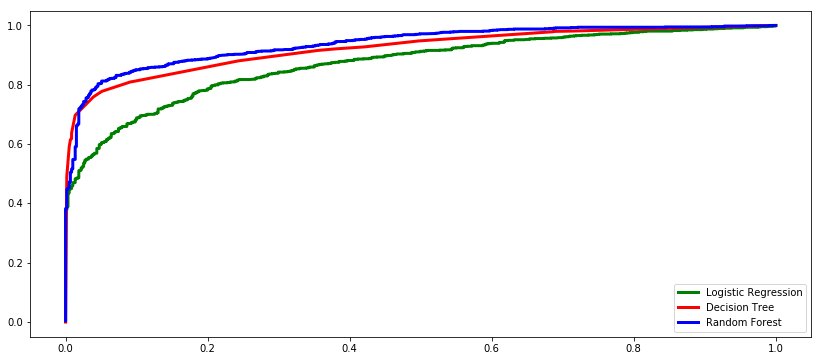

In [28]:
f1 = plt.figure(figsize=(14,6))

logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)
plot_roc(logreg, 'Logistic Regression', 'green')

dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=6
)
plot_roc(dtree, 'Decision Tree', 'red')

rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=10,
    n_estimators=100
)
plot_roc(rforest, 'Random Forest', 'blue')

#gbm = GradientBoostingClassifier(
#    random_state=random_state, 
#    max_depth=6,
#    n_estimators=100
#)
#plot_roc(gbm, 'GBM', 'lightblue')

plt.legend(loc='lower right')